In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
!pwd
%cd "/content/gdrive/Shareddrives/PPEREZ IA/Dataset/Procesado2"
!ls

Mounted at /content/gdrive
/content
/content/gdrive/Shareddrives/PPEREZ IA/Dataset/Procesado2
x_test.csv  x_train.csv  y_test.csv  y_train.csv


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv('x_train.csv')
# df_x_train = pd.read_csv('x_train.csv')
df_y_train = pd.read_csv('y_train.csv')

df2 = pd.read_csv('x_test.csv')
# df_x_test = pd.read_csv('x_test.csv')
df_y_test = pd.read_csv('y_test.csv')

## Preprocesado del dataframe

In [4]:
# df_x_train = df_x_train.drop(columns=['differenceVector'])

In [5]:
# df_x_test = df_x_test.drop(columns=['differenceVector'])

In [6]:
def string_to_numpy_array(s):
    # Remove square brackets and split by whitespace
    s = s.strip("[]")
    elements = [float(e) for e in s.split()]
    return np.array(elements)

# Apply the custom function to the 'differenceVector' column
df['differenceVector'] = df['differenceVector'].apply(string_to_numpy_array)
df2['differenceVector'] = df2['differenceVector'].apply(string_to_numpy_array)

In [7]:
vectors_list = df['differenceVector'].tolist()
columns_to_include = ['cosSimMeanDistComments','cosSimMarkovComments','cosSimTokens','cosSim', 'euclidean', 'manhattan', 'jaccard', 'differenceVector']
selected_columns = df[columns_to_include]
df_x_train = selected_columns.drop(columns=['differenceVector'])
df_x_train = pd.concat([df['differenceVector'].apply(pd.Series), df_x_train], axis=1)

In [8]:
vectors_list = df2['differenceVector'].tolist()
columns_to_include = ['cosSimMeanDistComments','cosSimMarkovComments','cosSimTokens','cosSim', 'euclidean', 'manhattan', 'jaccard', 'differenceVector']
selected_columns = df2[columns_to_include]
df_x_test = selected_columns.drop(columns=['differenceVector'])
df_x_test = pd.concat([df2['differenceVector'].apply(pd.Series), df_x_test], axis=1)

In [9]:
print("df_x_train DataFrame:")
print(df_x_train)

df_x_train DataFrame:
            0         1         2    3    4         5         6    7  \
0    0.000000  0.007937  0.182540  0.0  0.0 -0.047619  0.000000  0.0   
1    0.000000  0.017241 -0.007543  0.0  0.0 -0.009698  0.000000  0.0   
2    0.000000  0.044444 -0.044444  0.0  0.0  0.000000  0.000000  0.0   
3    0.000000  0.064935 -0.071429  0.0  0.0  0.006494  0.000000  0.0   
4    0.000000 -0.065611  0.047511  0.0  0.0  0.018100  0.000000  0.0   
..        ...       ...       ...  ...  ...       ...       ...  ...   
735  0.000000  0.000000  0.000000  0.0  0.0  0.000000  0.000000  0.0   
736  0.000000 -0.063077  0.058462  0.0  0.0  0.000000  0.001538  0.0   
737  0.028521 -0.104278  0.046346  0.0  0.0  0.029412  0.000000  0.0   
738  0.002679 -0.016964  0.011607  0.0  0.0  0.002679  0.000000  0.0   
739  0.000000 -0.102757  0.097744  0.0  0.0  0.005013  0.000000  0.0   

            8         9  ...  141  142  143  cosSimMeanDistComments  \
0   -0.142857  0.000000  ...  NaN  NaN  Na

In [10]:
print("df_x_test DataFrame:")
print(df_x_test)

df_x_test DataFrame:
            0         1         2    3    4         5         6         7  \
0    0.000000 -0.024476  0.010490  0.0  0.0  0.013986  0.000000  0.000000   
1    0.000000  0.173077  0.000000  0.0  0.0 -0.173077  0.000000  0.000000   
2   -0.027778 -0.021368  0.027778  0.0  0.0  0.021368  0.000000  0.000000   
3   -0.011364 -0.037879  0.049242  0.0  0.0  0.000000  0.000000  0.000000   
4    0.000000 -0.131579  0.093301  0.0  0.0  0.038278  0.000000  0.000000   
..        ...       ...       ...  ...  ...       ...       ...       ...   
250 -0.033481 -0.221460  0.150464  0.0  0.0  0.000000  0.000000  0.104478   
251  0.002747 -0.038462  0.035714  0.0  0.0  0.000000  0.000000  0.000000   
252  0.019608 -0.033613  0.030812  0.0  0.0  0.000000 -0.012605  0.000000   
253  0.041126 -0.031385 -0.009740  0.0  0.0  0.000000  0.000000  0.000000   
254 -0.008961 -0.080645  0.047491  0.0  0.0  0.027778  0.000000  0.000000   

            8         9  ...  141  142  143  cosSimMea

In [11]:
df_x_train_filled = df_x_train.fillna(0)

In [12]:
df_x_test_filled = df_x_test.fillna(0)

In [13]:
df_x_test_filled.columns = df_x_test_filled.columns.astype(str)

In [14]:
# column_numbers = range(960, 899, -1)

# # Get the index position of the column 'cosSimTokens'
# insert_index = df_x_test_filled.columns.get_loc('cosSimMeanDistComments')

# # Add the new columns to df_x_test_filled and fill them with zeros
# for col_number in column_numbers:
#     col_name = str(col_number)
#     df_x_test_filled.insert(insert_index, col_name, 0)

In [15]:
# columns_list = df_x_test_filled.columns.tolist()
# print(columns_list)

In [16]:
print(df_x_test_filled)

            0         1         2    3    4         5         6         7  \
0    0.000000 -0.024476  0.010490  0.0  0.0  0.013986  0.000000  0.000000   
1    0.000000  0.173077  0.000000  0.0  0.0 -0.173077  0.000000  0.000000   
2   -0.027778 -0.021368  0.027778  0.0  0.0  0.021368  0.000000  0.000000   
3   -0.011364 -0.037879  0.049242  0.0  0.0  0.000000  0.000000  0.000000   
4    0.000000 -0.131579  0.093301  0.0  0.0  0.038278  0.000000  0.000000   
..        ...       ...       ...  ...  ...       ...       ...       ...   
250 -0.033481 -0.221460  0.150464  0.0  0.0  0.000000  0.000000  0.104478   
251  0.002747 -0.038462  0.035714  0.0  0.0  0.000000  0.000000  0.000000   
252  0.019608 -0.033613  0.030812  0.0  0.0  0.000000 -0.012605  0.000000   
253  0.041126 -0.031385 -0.009740  0.0  0.0  0.000000  0.000000  0.000000   
254 -0.008961 -0.080645  0.047491  0.0  0.0  0.027778  0.000000  0.000000   

            8         9  ...  141  142  143  cosSimMeanDistComments  \
0   

In [17]:
df_x_train_filled.columns = df_x_train_filled.columns.astype(str)

In [18]:
print(df_y_train)

     veredict
0           0
1           1
2           0
3           0
4           0
..        ...
735         1
736         1
737         1
738         1
739         1

[740 rows x 1 columns]


In [19]:
# Convert y_train to 1D array
df_y_train = df_y_train.values.ravel()

In [20]:
df_y_test = df_y_test.values.ravel()

## Best L2 Params

In [22]:
# param_grid = {
#     'penalty': ['l2'],
#     'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
#     'tol': [1e-4, 1e-3, 1e-2],
#     'fit_intercept': [True, False],
#     'solver': ['lbfgs', 'liblinear'],
#     'max_iter': [100, 500, 1000],
#     'class_weight': [None, 'balanced']
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, n_jobs=-1)

# # Fit the model
# grid_search.fit(df_x_train_filled, df_y_train)

# # Best parameters found
# print("Best parameters for LogisticRegression:", grid_search.best_params_)

In [23]:
# param_grid_rf = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'min_impurity_decrease': [0.0001, 0.001, 0.01, 0.002, 0.02, 0.2]  # L2-like parameter for tree regularization
# }
# # Initialize GridSearchCV with 5-fold cross-validation
# grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5)

# # Fit the model
# grid_search_rf.fit(df_x_train_filled, df_y_train)

# # Best parameters found
# print("Best parameters for RandomForestClassifier:", grid_search_rf.best_params_)

In [24]:
# param_grid_xgb = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.001, 0.01, 0.1],
#     'max_depth': [3, 6, 9],
#     'subsample': [0.7, 0.8, 0.9],
#     # 'reg_alpha': [0, 0.1, 0.5, 1],
#     'reg_lambda': [0.0001, 0.001, 0.01, 0.002, 0.02] # L2-like parameter
# }
# # Initialize GridSearchCV with 5-fold cross-validation
# grid_search_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='error'), param_grid_xgb, cv=5)

# # Fit the model
# grid_search_xgb.fit(df_x_train_filled, df_y_train)

# # Best parameters found
# print("Best parameters for XGBClassifier:", grid_search_xgb.best_params_)

## MODELO 1 (Logistic)

In [25]:
model1 = LogisticRegression(penalty='l2', C=0.0002, max_iter=1000, class_weight = "balanced", fit_intercept = False, solver = "lbfgs", tol = 0.0001)

In [26]:
model1.fit(df_x_train_filled, df_y_train)

LogisticRegression(C=0.0002, class_weight='balanced', fit_intercept=False,
                   max_iter=1000)

-------Logistic Results----------
Model accuracy on the training set: 0.7581081081081081
Model accuracy on the test set: 0.7215686274509804
Model accuracy on the validation set (cross-validation): 0.758108108108108
Confusion Matrix for the test set:
[[165   0]
 [ 71  19]]


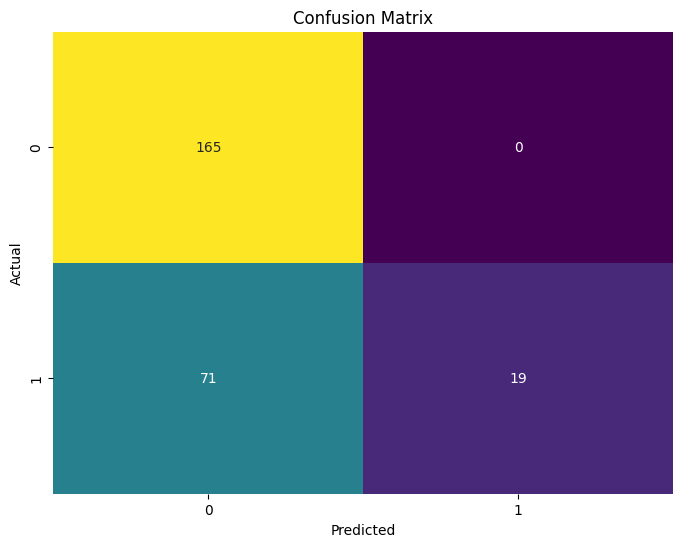


Classification Report for the test set:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82       165
           1       1.00      0.21      0.35        90

    accuracy                           0.72       255
   macro avg       0.85      0.61      0.59       255
weighted avg       0.81      0.72      0.66       255



In [27]:
# Make predictions on the training set
y_pred_train = model1.predict(df_x_train_filled)

# Calculate the accuracy of the model on the training set
accuracy_train = accuracy_score(df_y_train, y_pred_train)

# Print the accuracy on the training set
print ("-------Logistic Results----------")
print("Model accuracy on the training set:", accuracy_train)

# Make predictions on the test set
y_pred_test = model1.predict(df_x_test_filled)

# Calculate the accuracy of the model on the test set
accuracy_test = accuracy_score(df_y_test, y_pred_test)

# Print the accuracy on the test set
print("Model accuracy on the test set:", accuracy_test)

# Cross_val
# Perform cross-validation on the training set
cross_val_scores = cross_val_score(model1, df_x_train_filled, df_y_train, cv=5, scoring="accuracy")
cross_val_mean = cross_val_scores.mean()

# Print cross-validation accuracy
print("Model accuracy on the validation set (cross-validation):", cross_val_mean)

# Display the confusion matrix and classification report for the test set
conf_matrix = confusion_matrix(df_y_test, y_pred_test)
class_report = classification_report(df_y_test, y_pred_test)

print('Confusion Matrix for the test set:')
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

print('\nClassification Report for the test set:')
print(class_report)

## Modelo 2 (Random Forest)

In [71]:
from sklearn.utils.class_weight import compute_class_weight
# Convert to dictionary format required by the classifier
class_weight_dict = {0: 1, 1: 4}

In [72]:
model2 = RandomForestClassifier(class_weight = class_weight_dict, min_impurity_decrease = 0.00005, max_depth = 10, min_samples_leaf = 4, min_samples_split = 8, n_estimators = 3000, random_state=42, criterion='gini', max_features='sqrt', bootstrap=True, warm_start=True)

In [73]:
model2.fit(df_x_train_filled, df_y_train)

RandomForestClassifier(class_weight={0: 1, 1: 4}, max_depth=10,
                       min_impurity_decrease=5e-05, min_samples_leaf=4,
                       min_samples_split=8, n_estimators=3000, random_state=42,
                       warm_start=True)

-------Random Forest Results----------
Model accuracy on the training set: 0.9702702702702702
Model accuracy on the test set: 0.8588235294117647
Model accuracy on the validation set (cross-validation): 0.8162162162162161
Confusion Matrix for the test set:
[[154  11]
 [ 25  65]]


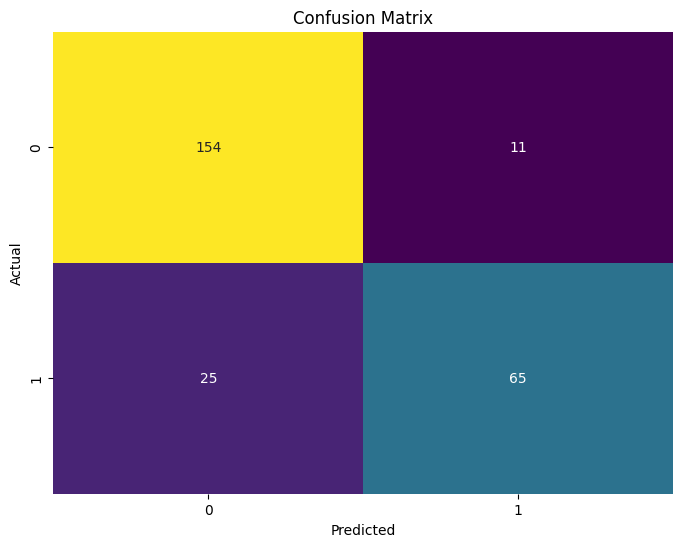


Classification Report for the test set:
              precision    recall  f1-score   support

           0       0.86      0.93      0.90       165
           1       0.86      0.72      0.78        90

    accuracy                           0.86       255
   macro avg       0.86      0.83      0.84       255
weighted avg       0.86      0.86      0.86       255



In [74]:
# Make predictions on the training set
y_pred_train = model2.predict(df_x_train_filled)

# Calculate the accuracy of the model on the training set
accuracy_train = accuracy_score(df_y_train, y_pred_train)

# Print the accuracy on the training set
print ("-------Random Forest Results----------")
print("Model accuracy on the training set:", accuracy_train)

# Make predictions on the test set
y_pred_test = model2.predict(df_x_test_filled)

# Calculate the accuracy of the model on the test set
accuracy_test = accuracy_score(df_y_test, y_pred_test)

# Print the accuracy on the test set
print("Model accuracy on the test set:", accuracy_test)

# Cross_val
# Perform cross-validation on the training set
cross_val_scores = cross_val_score(model2, df_x_train_filled, df_y_train, cv=10, scoring="accuracy")
cross_val_mean = cross_val_scores.mean()

# Print cross-validation accuracy
print("Model accuracy on the validation set (cross-validation):", cross_val_mean)

# Display the confusion matrix and classification report for the test set
conf_matrix = confusion_matrix(df_y_test, y_pred_test)
class_report = classification_report(df_y_test, y_pred_test)

print('Confusion Matrix for the test set:')
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

print('\nClassification Report for the test set:')
print(class_report)

## Modelo 3 (XGBoost)

In [32]:
model3 = xgb.XGBClassifier(learning_rate = 0.005, max_depth = 10, n_estimators = 2000, reg_lambda=0.00005, subsample = 0.6, tree_method = 'auto', scale_pos_weight = 1, seed = 42)

In [33]:
model3.fit(df_x_train_filled, df_y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.005, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

-------XGBoost Results----------
Model accuracy on the training set: 1.0
Model accuracy on the test set: 0.8392156862745098
Model accuracy on the validation set (cross-validation): 0.8108108108108109
Confusion Matrix for the test set:
[[154  11]
 [ 30  60]]


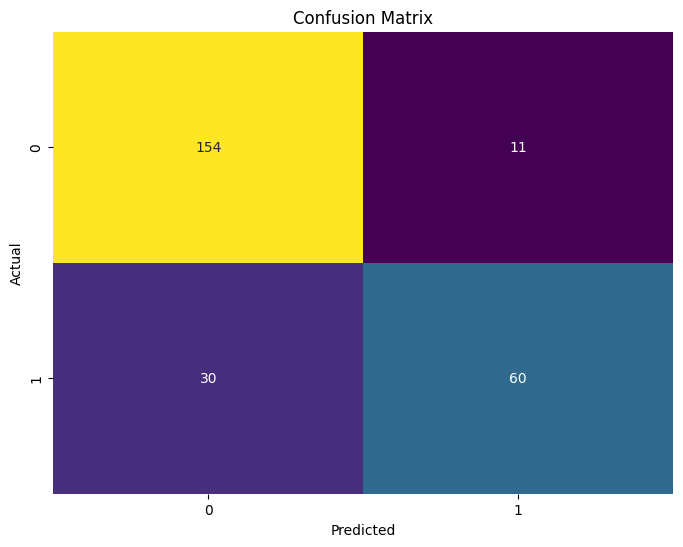


Classification Report for the test set:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       165
           1       0.85      0.67      0.75        90

    accuracy                           0.84       255
   macro avg       0.84      0.80      0.81       255
weighted avg       0.84      0.84      0.83       255



In [34]:
# Make predictions on the training set
y_pred_train = model3.predict(df_x_train_filled)

# Calculate the accuracy of the model on the training set
accuracy_train = accuracy_score(df_y_train, y_pred_train)

# Print the accuracy on the training set
print ("-------XGBoost Results----------")
print("Model accuracy on the training set:", accuracy_train)

# Make predictions on the test set
y_pred_test = model3.predict(df_x_test_filled)

# Calculate the accuracy of the model on the test set
accuracy_test = accuracy_score(df_y_test, y_pred_test)

# Print the accuracy on the test set
print("Model accuracy on the test set:", accuracy_test)

# Cross_val
# Perform cross-validation on the training set
cross_val_scores = cross_val_score(model3, df_x_train_filled, df_y_train, cv=5, scoring="accuracy")
cross_val_mean = cross_val_scores.mean()

# Print cross-validation accuracy
print("Model accuracy on the validation set (cross-validation):", cross_val_mean)

# Display the confusion matrix and classification report for the test set
conf_matrix = confusion_matrix(df_y_test, y_pred_test)
class_report = classification_report(df_y_test, y_pred_test)

print('Confusion Matrix for the test set:')
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

print('\nClassification Report for the test set:')
print(class_report)